### <mark> skip_gram
    
Skip-gram is one of the unsupervised learning techniques used to find the most related words for a given word.
    
Skip-gram is used to predict the context word for a given target word. It’s reverse of CBOW algorithm. Here, target word is input while context words are output. As there is more than one context word to be predicted which makes this problem difficult.
    
The skip-gram model is a method for learning word embeddings, which are continuous, dense, and low-dimensional representations of words in a vocabulary. It is trained using large amounts of unstructured text data and can capture the context and semantic similarity between words.
    
ARCHITECTURE
    
The architecture of the skip-gram model consists of an input layer, an output layer, and a hidden layer. The input layer is the word to be predicted, and the output layer is the context words. The hidden layer represents the embedding of the input word learned during training. The skip-gram model uses a feedforward neural network with a single hidden layer.
The model architecture should include embedding layers for the target and context words and a dense layer with a sigmoid activation function to predict the probability of the context word appearing within a fixed window of the target word. The trained word embeddings can be extracted from the model once trained. The model can then be compiled with a loss function, an optimizer, and fit on the skip grams.

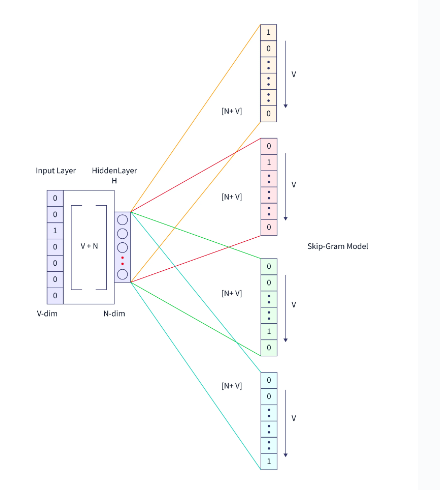

    1. w(t) is the target word or input given. 
    2. There is one hidden layer which performs the dot product between the weight matrix and the input vector w(t). No activation function is used in the hidden layer.
    3. result of the dot product at the hidden layer is passed to the output layer.
    4. Then we apply the softmax activation function to compute the probability of words appearing to be in the context of w(t) at given context location

### Variables we’ll be using

**INPUT**

    V : The dictionary of unique words present in our dataset or text. This dictionary is known as vocabulary and is known words to the system. Vocabulary is represented by ‘V’.
    
    |V| : The dimension of an input vector is equal to |V|. Each word is encoded using one hot encoding.
    
    c : The window size is the maximum context location at which the words need to be predicted. The window size is denoted by c. For example, in the given architecture image the window size is 2, therefore, we will be predicting the words at context location (t-2), (t-1), (t+1) and (t+2).
    
    k : 2*c Context window is the number of words to be predicted which can occur in the range of the given word. The value of a context window is double the window size that is 2*c and is represented by k. For the given image the value of the context window is 4.
    
**HIDDEN LAYER**

    N : is the number of neurons present in the hidden layer.
    
    W : weight matrix for the hidden layer(W) having dimension [|V|, N]
    
    H[N] : The output vector of the hidden layer
    
**OUTPUT**
    
    W' : weight matrix between the hidden and the output layer having dimension [N, |V|]
    
    U[|v|] : Output vector: The dot product between W’ and H gives us an output vector U[|v|].

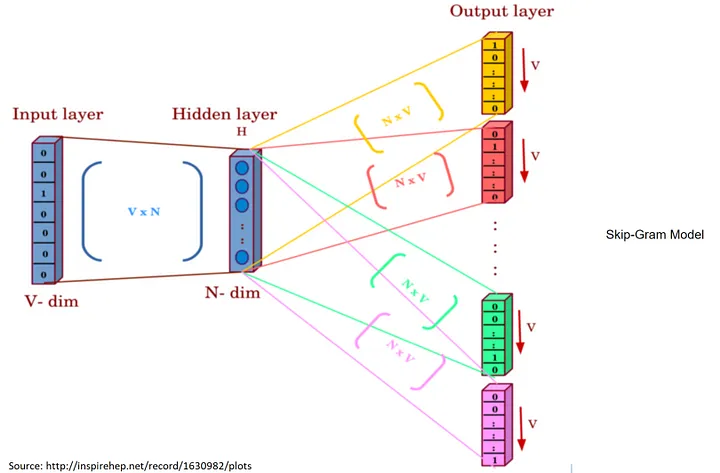

1. The words are converted into a vector using one hot encoding. The dimension of these vectors is [1,|v|].

2. The word w(t) is passed to the hidden layer from |v| neurons.

3. Hidden layer performs the dot product between weight vector W[|v|, N] and the input vector w(t). In this, we can conclude that the (t)th row of W[|v|, N] will be the output(H[1, N]).

4. Remember there is no activation function used at the hidden layer so the H[1,k]will be passed directly to the output layer.

5. Output layer will apply dot product between H[1, N] and W’[N, |v|] and will give us the vector U.

6. Now, to find the probability of each vector we’ll use the softmax function. As each iteration gives output vector U which is of one hot encoding type.

7. The word with the highest probability is the result and if the predicted word for a given context position is wrong then we’ll use backpropagation to modify our weight vectors W and W’.

This steps will be executed for each word w(t) present in vocabulary. And each word w(t) will be passed k times. So, we can see that forward propagation will be processed |v|*k times in each epoch.

IN CONCLUSION, the skip-gram model is a popular method for generating word embeddings, dense vector representations of words in a vocabulary.

The skip-gram model takes a large corpus of text as input and trains a neural network to predict the context words that appear within a target word's fixed window based on the text's co-occurrence.

The word embeddings can be extracted from the weights of the embedding layer in the trained model and can be used as input to other natural language processing tasks, such as text classification, sentiment analysis, and machine translation.

# EXAMPLE 1

### Build the Corpus Vocabulary

In [ ]:
import nltk
from nltk.corpus import gutenberg

# download and load the bible text from gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
bible_text = gutenberg.sents('bible-kjv.txt') 


from string import punctuation
import tensorflow as tf
import tf.keras
from keras.preprocessing import text

In [ ]:
bible_text

In [ ]:
# remove punctuation and numbers from the text
remove_chars = punctuation + '0123456789'
normalized_bible = [[word.lower() for word in sent if word not in remove_chars] for sent in bible_text]

# join the tokens back into a string
normalized_bible_text = [' '.join(tok_sent) for tok_sent in normalized_bible]

# remove empty strings and lines with fewer than three words
filtered_bible_text = list(filter(None, normalized_bible_text))
filtered_bible_text = [tok_sent for tok_sent in filtered_bible_text if len(tok_sent.split()) > 2]

print('Total number of lines in the original corpus:', len(bible_text))
print('\nOriginal sample line:', bible_text[5])
print('\nProcessed sample line:', filtered_bible_text[5])

# create a tokenizer and fit it on the text
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(filtered_bible_text)

# create mapping dictionaries for words to ids and ids to words
word_to_id = tokenizer.word_index
id_to_word = {v:k for k, v in word_to_id.items()}

# calculate the vocabulary size
vocab_size = len(word_to_id) + 1 
embedding_size = 100
# embedding_size is the length of the dense vector representation of each word.

# convert the text to a list of word ids
word_ids = [[word_to_id[w] for w in text.text_to_word_sequence(doc)] for doc in filtered_bible_text]
print('Vocabulary size:', vocab_size)
print('Vocabulary sample:', list(word_to_id.items())[:10])

### Build a Skip-gram [(target, context), relevancy] Generator

Generate skip grams from the preprocessed text. A skip-gram is a pair of words (the target word and the context word) and a label indicating whether the context word appears within a fixed window size of the target word in the input text. Skip grams are used as training data for the word embedding model.

In [ ]:
# generate skip-grams
skip_grams = [tf.keras.preprocessing.sequence.skipgrams(id, vocabulary_size=vocab_size, window_size=10) for id in word_ids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id_to_word[pairs[i][0]], pairs[i][0], 
          id_to_word[pairs[i][1]], pairs[i][1], 
          labels[i]))

### Build the Skip-Gram Model Architecture

In [ ]:
from tensorflow.keras.layers import Concatenate, Dense, Embedding, Reshape
from tensorflow.keras.models import Model

# Define the input layers for the target and context words
target_word_input = tf.keras.Input(shape=(1,))
context_word_input = tf.keras.Input(shape=(1,))

# Build skip-gram architecture
target_word_model = Embedding(vocab_size, embedding_size,
                              embeddings_initializer="glorot_uniform")(target_word_input)
target_word_model = Reshape((embedding_size,))(target_word_model)

context_word_model = Embedding(vocab_size, embedding_size,
                               embeddings_initializer="glorot_uniform")(context_word_input)
context_word_model = Reshape((embedding_size,))(context_word_model)

# Concatenate the output of the target and context models
merged = Concatenate(axis=1)([target_word_model, context_word_model])

# Add a dense layer and sigmoid activation
#  a sigmoid activation function to predict the probability of the context word appearing within a fixed window of the target word.
output = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(merged)

# Define the model
model = Model(inputs=[target_word_input, context_word_input], outputs=output)

# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam")

# View model summary
print(model.summary())

### train the model on the skip-grams


In [ ]:
for epoch in range(1, 6):
    total_loss = 0
    for i, elem in enumerate(skip_grams):
        skip_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        skip_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [skip_first_elem, skip_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} skip-gram pairs'.format(i))
        total_loss += model.train_on_batch(X,Y)  

    print('Epoch: {} Loss: {}'.format(epoch, total_loss))

### Get Word Embeddings

To see results from the model, we first need to extract the trained word embeddings from the word embedding model. The word embeddings are the weights of the embedding layer, which are the dense vector representations of the words in the vocabulary. The shape of the weights tensor is (vocab_size, embedding_size), where vocab_size is the size of the vocabulary and embedding_size is the length of the dense vector representation of each word.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

# get the embeddings for the words in the vocabulary
weights = model.layers[2].get_weights()[0]

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

print(similar_words)

# reduce the dimensions of the embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(weights)

# create a list of the words in the vocabulary
words = [id2word[i] for i in range(1, vocab_size)]

# plot the similar words
fig, ax = plt.subplots(figsize=(20,10))
for word in similar_words:
    ax.scatter(vectors_2d[word2id[word]-1, 0], vectors_2d[word2id[word]-1, 1], c='red', label=word)
    for sim_word in similar_words[word]:
        ax.scatter(vectors_2d[word2id[sim_word]-1, 0], vectors_2d[word2id[sim_word]-1, 1], c='blue')
        ax.annotate(sim_word, (vectors_2d[word2id[sim_word]-1, 0], vectors_2d[word2id[sim_word]-1, 1]))
ax.legend()
plt.show()

# EXAMPLE 2

In [19]:
import numpy as np 
import string 
from nltk.corpus import stopwords

In [20]:
def softmax(x): 
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x)) 
    return e_x / e_x.sum() 

In [21]:
class word2vec(object): 
    def __init__(self): 
        self.N = 10
        self.X_train = [] 
        self.y_train = [] 
        self.window_size = 2
        self.alpha = 0.001
        self.words = [] 
        self.word_index = {} 

    def initialize(self,V,data): 
        self.V = V 
        self.W = np.random.uniform(-0.8, 0.8, (self.V, self.N)) 
        self.W1 = np.random.uniform(-0.8, 0.8, (self.N, self.V)) 

        self.words = data 
        for i in range(len(data)): 
            self.word_index[data[i]] = i 

    def feed_forward(self,X): 
        self.h = np.dot(self.W.T,X).reshape(self.N,1) 
        self.u = np.dot(self.W1.T,self.h) 
        #print(self.u) 
        self.y = softmax(self.u) 
        return self.y 

    def backpropagate(self,x,t): 
        e = self.y - np.asarray(t).reshape(self.V,1) 
        # e.shape is V x 1 
        dLdW1 = np.dot(self.h,e.T) 
        X = np.array(x).reshape(self.V,1) 
        dLdW = np.dot(X, np.dot(self.W1,e).T) 
        self.W1 -=  self.alpha*dLdW1 
        self.W -= self.alpha*dLdW 

    def train(self,epochs): 
        for x in range(1,epochs+1):
            self.loss = 0
            for j in range(len(self.X_train)): 
                self.feed_forward(self.X_train[j]) 
                self.backpropagate(self.X_train[j],self.y_train[j]) 
                C = 0
                for m in range(self.V): 
                    if(self.y_train[j][m]): 
                        self.loss += -1*self.u[m][0] 
                        C += 1
                self.loss += C*np.log(np.sum(np.exp(self.u))) 
            print("epoch ",x, " loss = ",self.loss) 
            self.alpha *= 1/( (1+self.alpha*x) ) 
            
    def predict(self,word,number_of_predictions): 
        if word in self.words: 
            index = self.word_index[word] 
            X = [0 for i in range(self.V)] 
            X[index] = 1
            prediction = self.feed_forward(X) 
            output = {} 
            for i in range(self.V): 
                output[prediction[i][0]] = i 
            
            top_context_words = [] 
            for k in sorted(output,reverse=True): 
                top_context_words.append(self.words[output[k]]) 
                if(len(top_context_words)>=number_of_predictions): 
                    break

            return top_context_words 
        else: 
            print("Word not found in dicitonary") 

In [22]:
def preprocessing(corpus): 
    stop_words = set(stopwords.words('english'))	 
    training_data = [] 
    sentences = corpus.split(".") 
    for i in range(len(sentences)): 
        sentences[i] = sentences[i].strip() 
        sentence = sentences[i].split() 
        x = [word.strip(string.punctuation) for word in sentence if word not in stop_words] 
        x = [word.lower() for word in x] 
        training_data.append(x) 
    return training_data 

In [23]:
def prepare_data_for_training(sentences, w2v): 
    data = {} 
    for sentence in sentences: 
        for word in sentence: 
            if word not in data: 
                data[word] = 1
            else: 
                data[word] += 1
    V = len(data) 
    data = sorted(list(data.keys())) 
    vocab = {} 
    for i in range(len(data)): 
        vocab[data[i]] = i 
    
    for sentence in sentences: 
        for i in range(len(sentence)): 
            center_word = [0 for x in range(V)] 
            center_word[vocab[sentence[i]]] = 1
            context = [0 for x in range(V)] 
            
            for j in range(i-w2v.window_size,i+w2v.window_size): 
                if i!=j and j>=0 and j<len(sentence): 
                    context[vocab[sentence[j]]] += 1
            w2v.X_train.append(center_word) 
            w2v.y_train.append(context) 
    w2v.initialize(V,data) 

    return w2v.X_train,w2v.y_train 

In [24]:
corpus = "The earth revolves around the sun. The moon revolves around the earth"
epochs = 1000

In [25]:
training_data = preprocessing(corpus) 

In [26]:
training_data

[['the', 'earth', 'revolves', 'around', 'sun'],
 ['the', 'moon', 'revolves', 'around', 'earth']]

In [27]:
w2v = word2vec() 

In [28]:
prepare_data_for_training(training_data, w2v) 

([[0, 0, 0, 0, 0, 1],
  [0, 1, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0],
  [1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 0],
  [0, 0, 0, 0, 0, 1],
  [0, 0, 1, 0, 0, 0],
  [0, 0, 0, 1, 0, 0],
  [1, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0]],
 [[0, 1, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 1],
  [1, 1, 0, 0, 0, 1],
  [0, 1, 0, 1, 1, 0],
  [1, 0, 0, 1, 0, 0],
  [0, 0, 1, 0, 0, 0],
  [0, 0, 0, 1, 0, 1],
  [1, 0, 1, 0, 0, 1],
  [0, 1, 1, 1, 0, 0],
  [1, 0, 0, 1, 0, 0]])

In [29]:
w2v.train(epochs) 

epoch  1  loss =  42.67895152247635
epoch  2  loss =  42.595104839584096
epoch  3  loss =  42.51195439631279
epoch  4  loss =  42.429572762107135
epoch  5  loss =  42.34802930963531
epoch  6  loss =  42.26738987008013
epoch  7  loss =  42.18771643012039
epoch  8  loss =  42.109066873773706
epoch  9  loss =  42.03149477126652
epoch  10  loss =  41.95504921607628
epoch  11  loss =  41.87977471029039
epoch  12  loss =  41.80571109747955
epoch  13  loss =  41.732893541415685
epoch  14  loss =  41.66135254820054
epoch  15  loss =  41.59111402872631
epoch  16  loss =  41.52219939787412
epoch  17  loss =  41.454625706474246
epoch  18  loss =  41.388405801801355
epoch  19  loss =  41.32354851225321
epoch  20  loss =  41.26005885185156
epoch  21  loss =  41.19793824029437
epoch  22  loss =  41.13718473446771
epoch  23  loss =  41.077793267572
epoch  24  loss =  41.01975589231978
epoch  25  loss =  40.9630620250012
epoch  26  loss =  40.90769868757589
epoch  27  loss =  40.853650745323264
epoch 

In [30]:
w2v.predict("around",3)

['revolves', 'earth', 'the']

In [31]:
w2v.predict("around",5)

['revolves', 'earth', 'the', 'around', 'moon']

In [32]:
w2v.predict("sun",3)

['earth', 'moon', 'sun']

In [33]:
w2v.predict("earth",3)

['revolves', 'sun', 'the']

In [34]:
w2v.predict("jupiter",3)

Word not found in dicitonary
